In [3]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_tuner as kt

# Read the CSV file
df = pd.read_csv('/home/shivanshsinghSUREintern2024/iit_bhu/output_images/results.csv')

# Function to load and preprocess images
def load_image(image_path1, target_size=(128, 128)):
    image_path = f"/home/shivanshsinghSUREintern2024/iit_bhu/output_images/{image_path1}"
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0
    return image

# Load images and velocities
images1 = np.array([load_image(img) for img in df['filename1']])
images2 = np.array([load_image(img) for img in df['filename2']])
velocities = df['max_velocity'].values

# Reshape images to add channel dimension
images1 = np.expand_dims(images1, axis=-1)
images2 = np.expand_dims(images2, axis=-1)

# Split data into training and validation sets
X_train1, X_val1, y_train, y_val = train_test_split(images1, velocities, test_size=0.2, random_state=42)
X_train2, X_val2 = train_test_split(images2, test_size=0.2, random_state=42)

# Print data shapes for verification
print(X_train1.shape, X_train2.shape, y_train.shape)


(2999, 128, 128, 1) (2999, 128, 128, 1) (2999,)


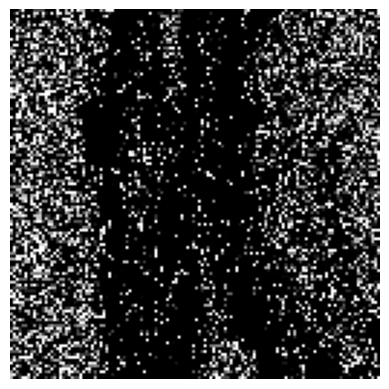

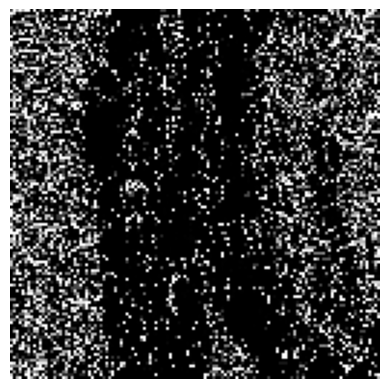

In [5]:
# Visualize some images
plt.imshow(images1[0].squeeze(), cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(images1[23].squeeze(), cmap='gray')
plt.axis('off')
plt.show()

In [6]:
# Define the Hypermodel
def build_model(hp):
    input1 = Input(shape=(128, 128, 1))
    input2 = Input(shape=(128, 128, 1))

    def cnn_branch(input):
        x = Conv2D(filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
                   kernel_size=(3, 3), activation='relu', padding='same')(input)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
                   kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(filters=hp.Int('filters_3', min_value=128, max_value=512, step=128),
                   kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Flatten()(x)
        return x

    branch1 = cnn_branch(input1)
    branch2 = cnn_branch(input2)

    concatenated = Concatenate()([branch1, branch2])

    x = Dense(units=hp.Int('units_1', min_value=64, max_value=256, step=64), activation='relu')(concatenated)
    x = Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(units=hp.Int('units_2', min_value=32, max_value=128, step=32), activation='relu')(x)
    x = Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1))(x)
    output = Dense(1)(x)

    model = Model(inputs=[input1, input2], outputs=output)

    model.compile(optimizer=Adam(learning_rate=hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

# Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='hyperband_dir',
                     project_name='velocity_prediction')


2024-07-13 11:34:41.306965: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Search for best hyperparameters
tuner.search([X_train1, X_train2], y_train, validation_data=([X_val1, X_val2], y_val), epochs=50, callbacks=[stop_early])

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
history = model.fit([X_train1, X_train2], y_train, validation_data=([X_val1, X_val2], y_val), epochs=50, batch_size=32)


Trial 30 Complete [00h 02m 26s]
val_loss: 0.049836866557598114

Best val_loss So Far: 0.049836866557598114
Total elapsed time: 00h 50m 22s
Epoch 1/50


94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - loss: 0.1746 - mae: 0.2640 - val_loss: 0.0557 - val_mae: 0.2005
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - loss: 0.0602 - mae: 0.1887 - val_loss: 0.0546 - val_mae: 0.1676
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - loss: 0.0572 - mae: 0.1829 - val_loss: 0.0515 - val_mae: 0.1794
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - loss: 0.0485 - mae: 0.1658 - val_loss: 0.0502 - val_mae: 0.1710
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - loss: 0.0440 - mae: 0.1572 - val_loss: 0.0523 - val_mae: 0.1609
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - loss: 0.0413 - mae: 0.1486 - val_loss: 0.0523 - val_mae: 0.1579
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - loss: 0.0357 - mae: 0.1406 - val_loss: 0.0500 - val_mae: 0.1622
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - loss: 0.0272 - mae: 0.1189 - val_loss: 0.0512 - val_mae: 0.1764
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - loss

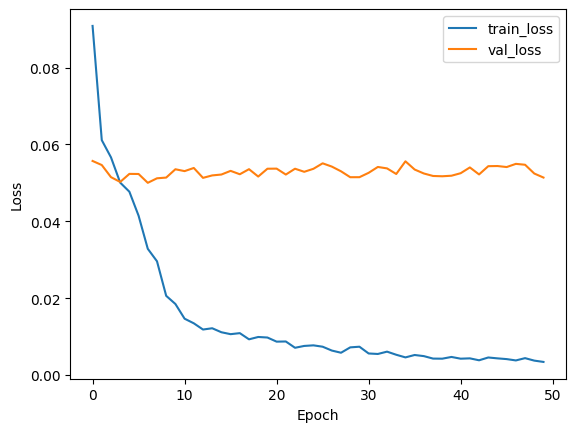

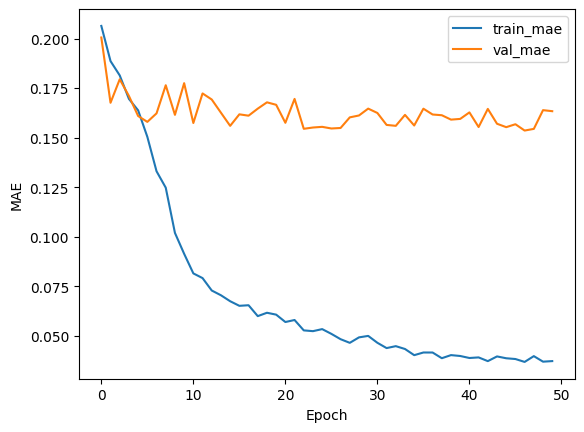

In [8]:
# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Save the model
model.save('best_cnn_velocity_prediction_model.h5')

In [9]:
# Load the model for future use
from tensorflow.keras.models import load_model
loaded_model = load_model('best_cnn_velocity_prediction_model.h5')

# Verify loaded model
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=-1)
    return image

def predict_velocity(model, image_path1, image_path2):
    image1 = load_and_preprocess_image(image_path1)
    image2 = load_and_preprocess_image(image_path2)
    image1 = np.expand_dims(image1, axis=0)
    image2 = np.expand_dims(image2, axis=0)
    predicted_velocity = model.predict([image1, image2])
    return predicted_velocity[0][0]

# Example usage
image_path1 = '/home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_0012.jpg'
image_path2 = '/home/shivanshsinghSUREintern2024/iit_bhu/output_images/frame_0013.jpg'
loaded_predicted_velocity = predict_velocity(loaded_model, image_path1, image_path2)
print(f"Loaded Model Predicted Velocity: {loaded_predicted_velocity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Loaded Model Predicted Velocity: 0.06472229957580566
